In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

## 例子

In [3]:
# src: UNet
class doubleConv(nn.Module):
    def __init__(self,in_channel,out_channel):
        super().__init__()
        self.doubleconv = nn.Sequential(
            nn.Conv2d(in_channel,out_channel,kernel_size=3,padding=1),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channel,out_channel,kernel_size=3,padding=1),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace=True)
        )
    
    def forward(self,x):
        x = self.doubleconv(x)
        return x

In [22]:
dc = doubleConv(8,16)

--------------

# nn.Sequential

需要注意的是，sequential对象是没有_parameters这个属性的！它只有_modules属性。  
只有继承nn.Module的对象才会同时有这两个属性。 
  
**sequential的这个特点易理解，毕竟其本质上可以看成一个nn.Module的集合，  
自然它本身是没有参数的。它其中的各个nn.Module才会有参数。**

In [12]:
print(dc._parameters)
print('-'*15)
print(dc._modules)

OrderedDict()
---------------
OrderedDict([('doubleconv', Sequential(
  (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
))])


<mark>对于sequential，如果想访问它其中的某个nn.Module(以访问doubleConv中的第一个Conv2d为例)，  方式可以如下：</mark>  


In [14]:
# 方法1
s1 = dc.doubleconv[0]

# 方法2
s2 = dc._modules['doubleconv'][0]

s1 == s2

True

<mark>**两种方法并没有区别，本质上都是先选中sequential对象，然后通过index访问具体的nn.Moudule**</mark>

---------------------------

# nn.Module

nn.Module主要被用来定义网络中的各种层结构。<br>
几乎所有的网络结构都要继承自nn.Module类。<br>
但是在这里，我们不去过多研究nn.Module，**我们只研究其中关于“访问具体层和参数”的部分。**<br><br>
详细的完整介绍，见：https://zhuanlan.zhihu.com/p/340453841


-------------------------------

## 1. _parameters和_modules

**我们的研究主要围绕nn.Module的两个属性，_parameters和_modules**  
<mark>它们的数据类型都是OrderDict(①)</mark>，其特点是:  
&emsp;&emsp;**其key的排序原则和key-value对加入的顺序有关，而和字典序无关**  
&emsp;&emsp;具体例子见：https://zhuanlan.zhihu.com/p/138481512

In [59]:
# ①
'-> ',type(dc._parameters),type(dc._modules),' <-'

# '''
#     #统计参数总数量
#     #num_params = sum(param.numel() for param in model.parameters())
# '''

('-> ', collections.OrderedDict, collections.OrderedDict, ' <-')

<mark>OrderDict中的每一个key-value对，key就是定义网络时，self.v = XX中的v ②  
value就是对应的**对象**，其类型为**nn.parameter.Parameter / nn.Module的衍生类**③</mark>

In [68]:
# ②
for name,module in dc._modules.items():
    print('-> ',name,' <-')

->  doubleconv  <-


In [69]:
# ③
# 因为sequential没有_parameters对象，所以我们用它其中的一个nn.Module进行演示
temp = dc.doubleconv[0]

for name,module in temp._modules.items():
    print('-> ',name,' | ',type(module),' <-')

print('-'*25)

for name,param in temp._parameters.items():
    print('-> ',name,' | ',type(param),' <-')

-------------------------
->  weight  |  <class 'torch.nn.parameter.Parameter'>  <-
->  bias  |  <class 'torch.nn.parameter.Parameter'>  <-


## 2. 底层细节

在自定义网络层@的时候，我们往往要做这些动作：  
&emsp;&emsp;1.定义类，这个类继承自nn.Module类，并且对这个父类进行初始化  
&emsp;&emsp;2.定义这个自定义层(类)中的类成员 (参数 / 子网络层(sequence or nn中的网络层，比如Conv2D))

这些动作的过程中，因为nn.Module重载了Object的\__set_attr__函数，  
所以对于这个自定义层(类)中定义的每一个类成员，底层发生的事情是：<mark>(对应👇例子)</mark>  
&emsp;&emsp;如果它的类型是nn.Parameter(等价于nn.parameter.Parameter)，就把它加入@._parameters中；①  
&emsp;&emsp;如果它的类型是子网络层，比如Conv2D / 其他自定义网络层，则把它加入到@._modules中。②  

&emsp;&emsp;最后再调用Object.\__set_attr__函数，<mark>使得可以通过定义@.XX来访问@的类成员XX</mark>(这个过程本质上调用\__get_attr__方法)③  

** 关于\__set_attr__，见：https://zhuanlan.zhihu.com/p/101004827?from_voters_page=true  

更多见: https://zhuanlan.zhihu.com/p/340453841  

In [53]:
#src: https://zhuanlan.zhihu.com/p/138481512
class Linear(nn.Module):
    def __init__(self, input_features, output_features):
        nn.Module.__init__(self)
        self.w = nn.Parameter(torch.rand(size=(input_features, output_features)))
        self.b = nn.Parameter(torch.rand(size=(output_features, 1)))
        self.layer_inner = nn.Conv2d(32,32,3,2,1) 
    def forward(self, input):
        return torch.sigmoid(input @ self.w + self.b)
    
l1 = Linear(28*28,72)

In [44]:
# ①
for name,param in l1._parameters.items():
    print(name)

w
b


In [45]:
# ②
for name,param in l1._modules.items():
    print(name)

layer_inner


In [52]:
# ③
print(l1.layer_inner)
print('='*25)

#通常来说，Linear层的参数名是w和b，而Conv2D的参数名则是weights 和 bias
l1.layer_inner._parameters.keys()

Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))


odict_keys(['weight', 'bias'])

### 2.2 tensor和nn.parameter

<mark>注意到，nn.Parameter借助Tensor进行构造(Parameter定义时也是继承自Tensor的)。  
一个很自然的疑问是，Tensor已经支持requires_grad了，为什么还需要nn.Parameter？  
这是因为：  
&emsp;&emsp;有些网络层中，比如RNN，它之中的隐状态就是用Tenosr来表示的，来表达它不可学习(Tensor默认requires_grad=True)  
&emsp;&emsp;毕竟Torch是一个微分计算库，而不仅仅是神经网络库，所以Tensor是微分计算的基本单位，  
&emsp;&emsp;而Parameters只是单独为了神经网络设计的基本单位 易懂。 
</mark>  
  
** https://blog.csdn.net/weixin_36670529/article/details/106670359?utm_medium=distribute.pc_relevant.none-task-blog-BlogCommendFromBaidu-1.control&depth_1-utm_source=distribute.pc_relevant.none-task-blog-BlogCommendFromBaidu-1.control  
** https://blog.csdn.net/qq_28753373/article/details/104179354

<mark>并且Parameter中.data成员，就是一个Tensor</mark>

In [72]:
w = l1.layer_inner.weight
type(w),' | ',type(w.data)

(torch.nn.parameter.Parameter, ' | ', torch.Tensor)

<mark>默认下，定义tensor/parameter时，grad的初始值都是None & requires_grad都是False</mark>
<br><mark>并且，对于parameter来说，它grad存在parameter这一层，而不存在其.data的tensor中</mark>

In [113]:
import torch as t 

class LeNet(t.nn.Module): 
    def __init__(self): 
        super(LeNet, self).__init__() 
        self.features = t.nn.Sequential( 
            t.nn.Conv2d(3, 6, 5), 
            t.nn.ReLU(), 
            t.nn.MaxPool2d(2, 2), 
            t.nn.Conv2d(6, 16, 5), 
            t.nn.ReLU(), 
            t.nn.MaxPool2d(2, 2) 
        ) 

        # 由于调整shape并不是一个class层， 
        # 所以在涉及这种操作（非nn.Module操作）需要拆分为多个模型 
        self.classifiter = t.nn.Sequential( 
            t.nn.Linear(16*5*5, 120), 
            t.nn.ReLU(), 
            t.nn.Linear(120, 84), 
            t.nn.ReLU(), 
            t.nn.Linear(84, 10) 

        ) 

    def forward(self, x): 
        x = self.features(x) 
        x = x.view(-1, 16*5*5) 
        x = self.classifiter(x) 
        return x 

In [116]:
b = torch.rand((3,2))
ln = LeNet()
print(b.requires_grad,ln.features[0].weight.data.requires_grad)

False False


In [121]:
temp = torch.rand((1,3,32,32))
out = ln(temp)
out = out.sum()
print(ln.features[0].weight.grad,' | ',ln.features[0].weight.data.grad)
out.backward()
print(ln.features[0].weight.grad,' | ',ln.features[0].weight.data.grad)

tensor([[[[ 1.5991e-03, -1.3889e-03, -1.8735e-02,  8.2426e-03, -1.8305e-03],
          [-2.2605e-02, -1.2497e-02, -7.3121e-03, -8.9236e-03, -1.2307e-02],
          [-8.7537e-03, -9.0901e-03, -1.8419e-03, -3.8670e-03, -9.6481e-03],
          [-1.1980e-02, -1.7327e-02,  2.0799e-04, -1.6198e-02, -1.4674e-02],
          [-1.0800e-02, -1.5343e-02, -8.9835e-03, -1.4145e-02, -1.3662e-02]],

         [[-1.8858e-02, -8.3152e-03,  1.0297e-02,  5.2866e-03, -1.3558e-02],
          [-1.0172e-02, -1.2344e-02, -9.0746e-03, -1.3376e-02,  8.2008e-03],
          [ 5.7473e-03, -1.9177e-02, -2.7641e-02, -7.0467e-03, -1.7012e-02],
          [-1.4456e-02, -1.2831e-02, -3.5027e-03, -1.5472e-03, -5.1481e-03],
          [-1.0318e-03,  3.3965e-03, -7.1786e-03, -1.1437e-02, -2.6539e-03]],

         [[-1.4311e-02,  1.3111e-02, -1.3518e-02, -1.3461e-02, -6.3806e-03],
          [-2.5235e-02, -1.5150e-02, -1.6846e-02, -4.9508e-03, -2.0655e-02],
          [-2.2954e-02,  5.8642e-04, -5.3020e-03,  6.3386e-03, -8.1492e-

## 3. 参数初始化

<mark>各种初始化函数</mark>  
https://blog.csdn.net/u013978977/article/details/84861453  
https://www.jianshu.com/p/902bb29209ed  
同名函数(参数可能有些不同，因为有些是成员函数，有些是外部函数(nn.init) nm)，所以适用于下面所有的方法

### 3.1 遍历网络的参数，根据不同的网络参数进行初始化

#### 3.1.1 初始化nn.Parameter

In [96]:
# src: https://zhuanlan.zhihu.com/p/144864894 “二、初始化模型参数”

weight = l1.layer_inner.weight
print(weight[1:2,1:2])
print('-'*50)

# 方法1：直接初始化
with torch.no_grad():
# no_grad()必须，否则: RuntimeError: a leaf Variable that requires grad is being used in an in-place operation.
# nm为什么
    weight.uniform_(-10,10)
print(weight[1:2,1:2])
print('-'*50)

# 方法2：通过init初始化
nn.init.normal_(weight,mean=0,std=1)
print(weight[1:2,1:2])

# grad_fn=<SliceBackward> 和切片有关，nm即可

tensor([[[[-0.1789, -0.4402,  0.1513],
          [-1.0741, -1.3570, -0.3698],
          [-1.2287, -0.3229, -1.2037]]]], grad_fn=<SliceBackward>)
--------------------------------------------------
tensor([[[[-8.4682, -4.9271, -0.5134],
          [-5.2677, -8.3314,  1.6625],
          [ 2.5166,  7.9454,  9.4772]]]], grad_fn=<SliceBackward>)
--------------------------------------------------
tensor([[[[ 2.5896e+00, -3.9449e-01, -1.2874e+00],
          [ 4.9101e-01, -4.8053e-02,  2.0564e+00],
          [-1.7674e-03, -7.6380e-02,  2.9841e-01]]]], grad_fn=<SliceBackward>)


#### 3.1.2 初始化nn.Parameter中的Tensor

In [95]:
#src: https://zhuanlan.zhihu.com/p/190207193
weight = weight = l1.layer_inner.weight

weight.data.normal_(mean=-1,std=0.5)
print(weight[1:2,1:2])

tensor([[[[-0.1789, -0.4402,  0.1513],
          [-1.0741, -1.3570, -0.3698],
          [-1.2287, -0.3229, -1.2037]]]], grad_fn=<SliceBackward>)


### 3.2 自定义网络层中定义reset_parameters函数

https://blog.csdn.net/qq_28753373/article/details/104179354  

reset_parameter就是用来干这个的 checked <br>https://github.com/pytorch/pytorch/blob/master/torch/nn/modules/linear.py


### 3.3 基于net.apply()

https://blog.csdn.net/u013978977/article/details/84861453

## 4. 参数共享

<mark>共享参数可能会导致torchsummary参数统计不准确的问题</mark>，具体见：https://zhuanlan.zhihu.com/p/64425750

### 4.1 基于自定义层  
比如卷积层参数共享

In [112]:
#src: https://blog.csdn.net/qq_19672579/article/details/79373985
#链接中还有另外两个例子
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv_weight = nn.Parameter(torch.randn(3, 3, 5, 5))
 
    def forward(self, x):
        x = nn.functional.conv2d(x, self.conv_weight, bias=None, stride=1, padding=2, dilation=1, groups=1)
        x = nn.functional.conv2d(x, self.conv_weight.transpose(2, 3).contiguous(), bias=None, stride=1, padding=0, dilation=1,
                                 groups=1)
        return x

### 4.2 重复torch预定义层

In [99]:
#src: https://zhuanlan.zhihu.com/p/144864894
linear = nn.Linear(1, 1, bias=False)
net = nn.Sequential(linear, linear, linear, linear) 
print(net)
for name, param in net.named_parameters():
    nn.init.constant_(param, val=3)
    # print(name, param.data)

x = torch.ones(1, 1)
y = net(x).sum()
# print(y)
y.backward()
print(net[0].weight.grad)

Sequential(
  (0): Linear(in_features=1, out_features=1, bias=False)
  (1): Linear(in_features=1, out_features=1, bias=False)
  (2): Linear(in_features=1, out_features=1, bias=False)
  (3): Linear(in_features=1, out_features=1, bias=False)
)
tensor([[108.]])


In [100]:
net(x)

tensor([[81.]], grad_fn=<MmBackward>)

In [109]:
net[0].weight,' | ',net[0].bias

(Parameter containing:
 tensor([[3.]], requires_grad=True), ' | ', None)

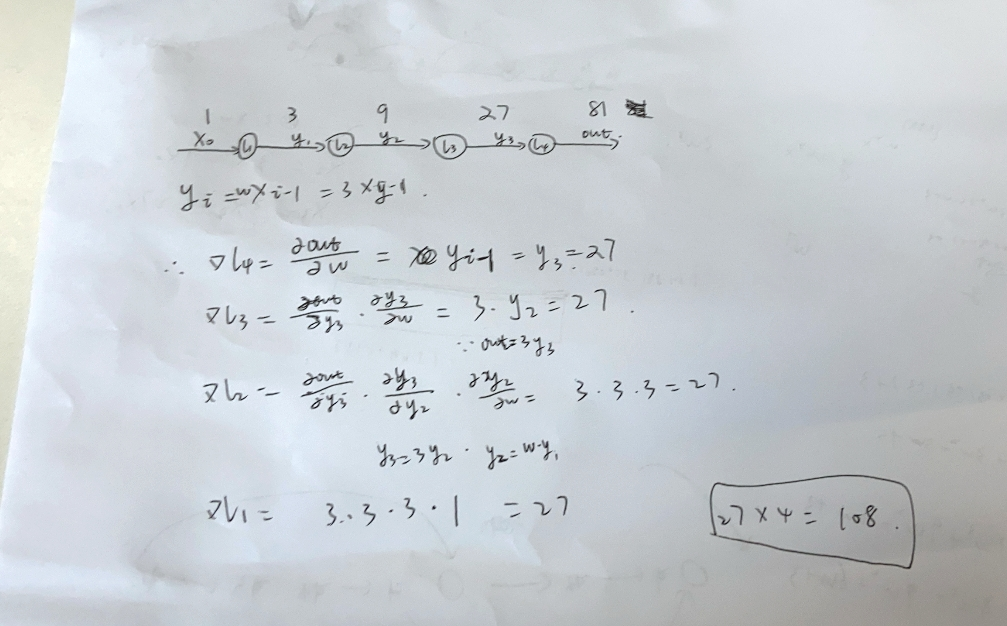

## 5. self.train() and self.eval()

--------------------